## Load Tensorboard

In [1]:
%load_ext tensorboard

## Import Libraries

In [2]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import InceptionResNetV2

## Initialize Tensorflow

In [3]:
from tensorflow.keras import backend as K
K.clear_session()

## Load Data

In [4]:
data = pd.read_csv("../labels.csv")
imgs = ["{}.jpg".format(x) for x in list(data.id)]
img_label = list(data['breed'])

# Split data into train and validation set equally
b_sp = StratifiedShuffleSplit(1, 0.1)
imgs = np.array(imgs)
img_label = np.array(img_label)
for train_idx, val_idx in b_sp.split(imgs, img_label):
    train_x = imgs[train_idx]
    train_y = img_label[train_idx]
    val_x = imgs[val_idx]
    val_y = img_label[val_idx]

train_y = train_y.astype(str)
val_y = val_y.astype(str)
train_data = pd.DataFrame({'id': train_x,'breed': train_y})
val_data = pd.DataFrame({'id': val_x,'breed': val_y})

In [5]:
BATCH_SIZE = 128

# Number of epochs for training
EPOCHS = 150

# The original image will be resized to the size specified below.
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Path to image for training
#TRAIN_PATH = '../img/train/'
TRAIN_PATH = '../img/train/'
TEST_PATH = '../img/test/'

## Preprocess Image

In [6]:
# For train image generator, more params may be added to generate augmented image.
train_image_generator = ImageDataGenerator(rescale=1./255)
val_image_generator = ImageDataGenerator(rescale=1./255)

In [7]:
train_data_gen = train_image_generator.flow_from_dataframe(
                                        dataframe = train_data,
                                        directory=TRAIN_PATH,x_col="id",
                                        y_col="breed",
                                        class_mode="categorical",
                                        target_size=(IMG_HEIGHT,IMG_WIDTH),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)
val_data_gen = val_image_generator.flow_from_dataframe(
                                        dataframe = val_data,
                                        directory=TRAIN_PATH,x_col="id",
                                        y_col="breed",
                                        class_mode="categorical",
                                        target_size=(IMG_HEIGHT,IMG_WIDTH),
                                        batch_size=BATCH_SIZE)

Found 9199 validated image filenames belonging to 120 classes.
Found 1023 validated image filenames belonging to 120 classes.


In [8]:
# For checking of class distribution in train and validation set
# If unused, leave this commented to reduce output on your screen.

# breedcnt = dict()
# breedcntval = dict()
# for i in train_data['breed']:
#     try:
#         breedcnt[i] += 1
#     except:
#         breedcnt[i] = 1
        
# for i in val_data['breed']:
#     try:
#         breedcntval[i] += 1
#     except:
#         breedcntval[i] = 1
        
# for i in breedcnt.keys():
#     print(i, " : ", breedcnt[i], " | ", breedcntval[i])

## Define Model

In [9]:
# Define you model here
# The model provided is just placeholder
# Do not modify the input shape and the output layer
def get_base_model():
    inceptionresnet_model = InceptionResNetV2(include_top=False, weights='imagenet',
                       input_shape=(IMG_HEIGHT,IMG_WIDTH, 3), pooling='avg')
    inceptionresnet_model.trainable = False
    inceptionresnet_model.summary()
    input1 = Input(shape=(IMG_HEIGHT,IMG_WIDTH, 3))
    inceptionresnet_layer = inceptionresnet_model(input1)
    out = Dense(120, activation='softmax')(inceptionresnet_layer)
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=SGD(0.005), loss='categorical_crossentropy',
                  metrics=['categorical_crossentropy','categorical_accuracy','accuracy'])
    
    return model

In [10]:
base_model = get_base_model()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

Total params: 54,336,736
Trainable params: 0
Non-trainable params: 54,336,736
__________________________________________________________________________________________________


In [11]:
# Total params should not exceed 120M or the VM may crash
base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
dense (Dense)                (None, 120)               184440    
Total params: 54,521,176
Trainable params: 184,440
Non-trainable params: 54,336,736
_________________________________________________________________


## Train the model

In [12]:
# Path to save model parameters
weight_path_model_base ='model_inceptionresnetv2.h5'
# Path to write tensorboard
tensorboard_path_model_base = 'Graphs/pattern_nn_inceptionresnetv2'

callbacks_list_model_base = [
    TensorBoard(log_dir=tensorboard_path_model_base, histogram_freq=1, write_graph=True, write_grads=True),
    ModelCheckpoint(
            weight_path_model_base,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-10),
    EarlyStopping(
        monitor='val_loss', 
        verbose=1,
        patience=20,
        mode='min',
        restore_best_weights=True)
]

# If get ResourceExhaustedError, Restart kernel, then reduce epoch size (in cell above)
history_base = base_model.fit_generator(train_data_gen, epochs=EPOCHS, verbose=1, validation_data=val_data_gen,
                                        callbacks=callbacks_list_model_base)

Epoch 1/150
71/72 [============================>.] - ETA: 0s - loss: 4.8808 - categorical_crossentropy: 4.8809 - categorical_accuracy: 0.0108 - accuracy: 0.0108
Epoch 00001: val_loss improved from inf to 6.32084, saving model to model_inceptionresnetv2.h5
72/72 [==============================] - 72s 1s/step - loss: 4.8788 - categorical_crossentropy: 4.8789 - categorical_accuracy: 0.0108 - accuracy: 0.0108 - val_loss: 6.3208 - val_categorical_crossentropy: 6.3208 - val_categorical_accuracy: 0.0225 - val_accuracy: 0.0225
Epoch 2/150
71/72 [============================>.] - ETA: 0s - loss: 4.7478 - categorical_crossentropy: 4.7477 - categorical_accuracy: 0.0208 - accuracy: 0.0208
Epoch 00002: val_loss improved from 6.32084 to 5.60354, saving model to model_inceptionresnetv2.h5
72/72 [==============================] - 67s 927ms/step - loss: 4.7483 - categorical_crossentropy: 4.7482 - categorical_accuracy: 0.0210 - accuracy: 0.0210 - val_loss: 5.6035 - val_categorical_crossentropy: 5.6035 -

71/72 [============================>.] - ETA: 0s - loss: 3.8552 - categorical_crossentropy: 3.8551 - categorical_accuracy: 0.2264 - accuracy: 0.2264
Epoch 00016: val_loss improved from 2.53049 to 2.46095, saving model to model_inceptionresnetv2.h5
72/72 [==============================] - 67s 937ms/step - loss: 3.8533 - categorical_crossentropy: 3.8532 - categorical_accuracy: 0.2270 - accuracy: 0.2270 - val_loss: 2.4610 - val_categorical_crossentropy: 2.4611 - val_categorical_accuracy: 0.4448 - val_accuracy: 0.4448
Epoch 17/150
71/72 [============================>.] - ETA: 0s - loss: 3.8178 - categorical_crossentropy: 3.8179 - categorical_accuracy: 0.2377 - accuracy: 0.2377
Epoch 00017: val_loss improved from 2.46095 to 2.40301, saving model to model_inceptionresnetv2.h5
72/72 [==============================] - 68s 942ms/step - loss: 3.8180 - categorical_crossentropy: 3.8182 - categorical_accuracy: 0.2372 - accuracy: 0.2372 - val_loss: 2.4030 - val_categorical_crossentropy: 2.4028 - val

72/72 [==============================] - 65s 896ms/step - loss: 3.4768 - categorical_crossentropy: 3.4770 - categorical_accuracy: 0.2975 - accuracy: 0.2975 - val_loss: 2.0705 - val_categorical_crossentropy: 2.0707 - val_categorical_accuracy: 0.5386 - val_accuracy: 0.5386
Epoch 32/150
71/72 [============================>.] - ETA: 0s - loss: 3.4655 - categorical_crossentropy: 3.4655 - categorical_accuracy: 0.3104 - accuracy: 0.3104
Epoch 00032: val_loss improved from 2.07049 to 2.06226, saving model to model_inceptionresnetv2.h5
72/72 [==============================] - 65s 900ms/step - loss: 3.4670 - categorical_crossentropy: 3.4669 - categorical_accuracy: 0.3109 - accuracy: 0.3109 - val_loss: 2.0623 - val_categorical_crossentropy: 2.0625 - val_categorical_accuracy: 0.5455 - val_accuracy: 0.5455
Epoch 33/150
71/72 [============================>.] - ETA: 0s - loss: 3.4448 - categorical_crossentropy: 3.4450 - categorical_accuracy: 0.3100 - accuracy: 0.3100
Epoch 00033: val_loss improved fr

Epoch 48/150
71/72 [============================>.] - ETA: 0s - loss: 3.2892 - categorical_crossentropy: 3.2890 - categorical_accuracy: 0.3410 - accuracy: 0.3410
Epoch 00048: val_loss did not improve from 2.05034
72/72 [==============================] - 65s 901ms/step - loss: 3.2890 - categorical_crossentropy: 3.2888 - categorical_accuracy: 0.3412 - accuracy: 0.3412 - val_loss: 2.0585 - val_categorical_crossentropy: 2.0587 - val_categorical_accuracy: 0.5650 - val_accuracy: 0.5650
Epoch 49/150
71/72 [============================>.] - ETA: 0s - loss: 3.2872 - categorical_crossentropy: 3.2875 - categorical_accuracy: 0.3434 - accuracy: 0.3434
Epoch 00049: val_loss did not improve from 2.05034
72/72 [==============================] - 64s 888ms/step - loss: 3.2870 - categorical_crossentropy: 3.2872 - categorical_accuracy: 0.3435 - accuracy: 0.3435 - val_loss: 2.0588 - val_categorical_crossentropy: 2.0591 - val_categorical_accuracy: 0.5660 - val_accuracy: 0.5660
Epoch 50/150
71/72 [==========

## Train Logs

In [13]:
# What is tracked
print(history_base.history.keys())

dict_keys(['loss', 'categorical_crossentropy', 'categorical_accuracy', 'accuracy', 'val_loss', 'val_categorical_crossentropy', 'val_categorical_accuracy', 'val_accuracy', 'lr'])


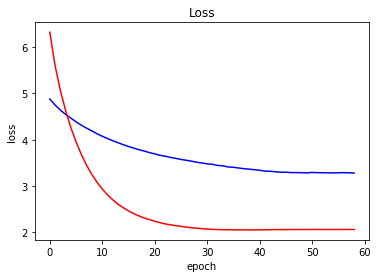

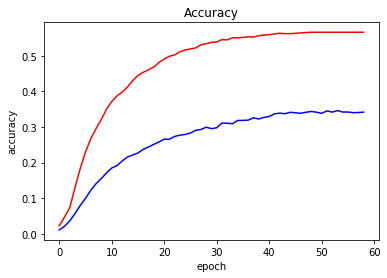

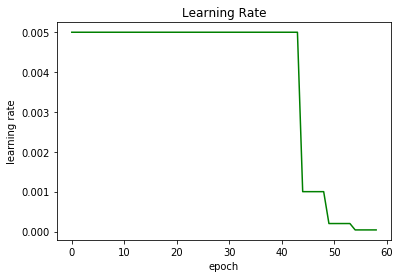

In [14]:
train_loss = history_base.history['loss']
train_acc = history_base.history['accuracy']
val_loss = history_base.history['val_loss']
val_acc = history_base.history['val_accuracy']
learnrate = history_base.history['lr']

plt.plot(train_loss, color='blue')
plt.plot(val_loss, color='red')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(train_acc, color='blue')
plt.plot(val_acc, color='red')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(learnrate, color='green')
plt.title('Learning Rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show()

## Load class details

In [15]:
classes = train_data_gen.class_indices

In [16]:
inverted_classes = dict(map(reversed, classes.items()))

In [17]:
class_list = [i for i in classes.keys()]

## Load test data

In [18]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=TEST_PATH,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode=None)

Found 10357 images belonging to 1 classes.


## Run on test data

In [19]:
test_result = base_model.predict_generator(test_data_gen, verbose=1)

81/81 [==============================] - 98s 1s/step


## Prepare data for csv

In [20]:
filenames = [i[i.find('/')+1:i.rfind('.')] for i in test_data_gen.filenames]
filenames_arr = np.array(filenames)[np.newaxis].T
test_result_with_label = np.concatenate((filenames_arr, test_result), axis=1)
csv_header = ['id'] + class_list

## Export data to csv

In [21]:
# Be aware that the file with the same name should not exist, or it will be overwrited.
result_dataframe = pd.DataFrame(test_result_with_label, columns=csv_header)
result_dataframe.to_csv('./result_inceptionresnetv2.csv', index=False)